import libraries and initial dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from datasets import load_from_disk
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap
import os

In [31]:
final_dataset = load_from_disk("wikiart_preprocessed")

train test split 80/20

In [32]:
split = final_dataset.train_test_split(test_size=0.2)
train_dataset_hf = split["train"]
test_dataset_hf = split["test"]

create image preprocessing pipeline that converts image to pytorch tensor dataset to use in cnn and normalize so large image values like black and white don't take over ... puts in [-1,1]

In [33]:
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [34]:
class WikiArtTorchDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]  
        image = example["image_compressed"]
        label = example["label"]
        if self.transform:
            image = self.transform(image)
        return image, label


In [35]:
train_data = WikiArtTorchDataset(train_dataset_hf, transform=cnn_transform)
test_data = WikiArtTorchDataset(test_dataset_hf, transform=cnn_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

Create CNN structure and model params and save to device so that it's faster!

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) # there are two classes as results
model = model.to(device)

/Users/maiaposternack/Desktop/hist2029/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maiaposternack/Desktop/hist2029/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
torch_dataset = WikiArtTorchDataset(final_dataset, transform=cnn_transform)
dataloader = DataLoader(torch_dataset, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

We find the initial loss so we have something to compare it to

In [ ]:
model.eval()
total_loss = 0
progress_bar = tqdm(test_loader, desc="Testing")
for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
avg_loss = total_loss / len(test_loader)
print(f"Initial loss: {avg_loss:.4f}")

Testing: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it, loss=0.933]

Initial loss: 0.9258


Train! 4 epochs because loss increases so fast that it is not worth it do more! (since loss increases on epoch 5)

In [40]:
for epoch in range(4):
    print(f"Epoch {epoch+1}/4")
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/4")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}")

Epoch 1/4


Epoch 1/4: 100%|██████████| 56/56 [03:43<00:00,  4.00s/it, loss=0.0727] 


Epoch 1 completed - Avg Loss: 0.0506
Epoch 2/4


Epoch 2/4: 100%|██████████| 56/56 [06:27<00:00,  6.92s/it, loss=0.00467]


Epoch 2 completed - Avg Loss: 0.0145
Epoch 3/4


Epoch 3/4: 100%|██████████| 56/56 [03:41<00:00,  3.95s/it, loss=0.00231] 


Epoch 3 completed - Avg Loss: 0.0057
Epoch 4/4


Epoch 4/4: 100%|██████████| 56/56 [03:38<00:00,  3.90s/it, loss=0.00194] 

Epoch 4 completed - Avg Loss: 0.0024


Evaluate on test set for robustness.... we have so much data that it didn't really affect the model that we withheld this 

In [ ]:
model.eval()
correct = 0
total = 0
progress_bar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        progress_bar.set_postfix(loss=loss.item())
accuracy = correct / total
print(f"\nTest Accuracy: {accuracy:.2%}")

Testing:   0%|          | 0/14 [00:24<?, ?it/s, loss=0.00194]


Test Accuracy: 96.76%


In [42]:
model.eval()
total_loss = 0
progress_bar = tqdm(test_loader, desc="Testing")
for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
avg_loss = total_loss / len(test_loader)
print(f"Final loss: {avg_loss:.4f}")

Testing: 100%|██████████| 14/14 [00:23<00:00,  1.64s/it, loss=0.0429]

Final loss: 0.1030


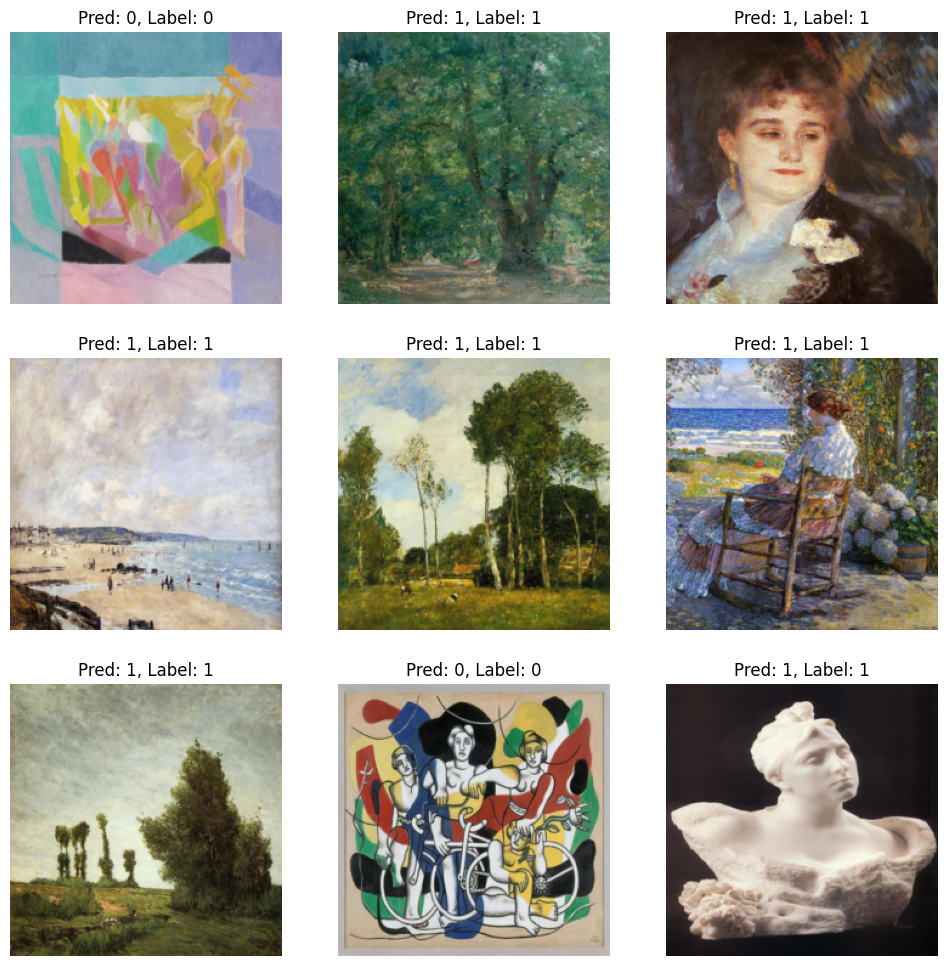

In [58]:
model.eval()
cubism_preds = []
imp_preds = []
titles = []
preds = []

with torch.no_grad():
    for i in range(9):
        item = test_dataset_hf[i]
        image = item["image_compressed"]
        label = item["label"]
        image_tensor = cnn_transform(image).unsqueeze(0).to(device)
        
        output = model(image_tensor)
        pred = output.argmax(dim=1).item()
        preds.append(image)
        titles.append(f"Pred: {pred}, Label: {label}")

# Display them
def show_images(images, titles):
    plt.figure(figsize=(12, 12))
    for i, img in enumerate(images):
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

show_images(preds, titles)


Now we implement the grad-cam overlay. Noting what parts of the image are most important for classification. And save for future use!

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam


In [ ]:
def show_comparison(
    original_image,
    image_tensor,
    cam,
    label,
    pred,
    sharpen=True,
    top_percentile=None,
    save_path="gradcam_comparison.png",
    
):
    # Resize Grad-CAM to 224x224
    cam_resized = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam_resized = F.interpolate(cam_resized, size=(224, 224), mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().numpy()

    # Sharpen the heatmap
    if sharpen:
        cam_resized = np.clip(cam_resized - cam_resized.mean(), 0, 1)
        cam_resized /= cam_resized.max() + 1e-8

    # Top percentile masking
    if top_percentile:
        threshold = np.percentile(cam_resized, top_percentile)
        cam_resized = np.where(cam_resized >= threshold, 1.0, 0.0)

    # Convert image tensor
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # Create 1-color colormap
    cmap = LinearSegmentedColormap.from_list("custom", [(1, 1, 1, 0), (1, 0, 0, 1)])  # red

    heatmap = cmap(cam_resized)[..., :3]
    overlay = 0.5 * heatmap + 0.5 * image
    overlay = np.clip(overlay, 0, 1)

    # Plot
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original\nLabel: {label}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM\nPredicted: {pred}")
    plt.axis("off")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=150)
    plt.close()



In [84]:
gradcam = GradCAM(model, model.layer4[1].conv2)

for i in range(len(test_dataset_hf)):
    if i % 100 == 0:
        print(f"Processing sample {i}/{len(test_dataset_hf)}")
    item = test_dataset_hf[i]
    original = item["image"]
    compressed = item["image_compressed"]
    label = item["label"]

    image_tensor = cnn_transform(compressed)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    cam = gradcam.generate(input_tensor)

    save_path = f"grad-cam-images/cat_{pred}_sample_{i}.png"

    show_comparison(
        original,
        image_tensor,
        cam,
        label,
        pred,
        sharpen=True,
        top_percentile=90,
        save_path=save_path
    )



Processing sample 0/894


/Users/maiaposternack/Desktop/hist2029/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Processing sample 100/894
Processing sample 200/894
Processing sample 300/894
Processing sample 400/894
Processing sample 500/894
Processing sample 600/894
Processing sample 700/894
Processing sample 800/894


HOW MUCH DOES COLOR MATTER?

In [85]:
gray_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    progress = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            current_accuracy = correct / total
            progress.set_postfix(accuracy=f"{current_accuracy:.2%}")

    final_accuracy = correct / total
    print(f"Final Accuracy: {final_accuracy:.2%}")
    return final_accuracy


In [91]:
gray_dataset = WikiArtTorchDataset(test_dataset_hf, transform=gray_transform)
gray_loader = DataLoader(gray_dataset, batch_size=32)

print("for colors")
evaluate(model, test_loader, device)      
print("for gray")
evaluate(model, gray_loader, device)      

for colors


Final Accuracy: 96.76%
for gray


Final Accuracy: 94.97%


0.9496644295302014

Since there is very little difference in the accuraries we see that color is not a primary differentiator in classification (although it is slightly relevent)